# Virus-Host Species Relation Extraction
## Notebook 4
### UC Davis Epicenter for Disease Dynamics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
from snorkel import SnorkelSession
import pandas as pd
session = SnorkelSession()
# Connect to the database backend and initalize a Snorkel session

#from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

VirusHost = candidate_subclass('VirusHost', ['virus', 'host'])

In [2]:
from snorkel.annotations import load_marginals

train_cands = session.query(VirusHost).filter(VirusHost.split == 0).order_by(VirusHost.id).all()
dev_cands   = session.query(VirusHost).filter(VirusHost.split == 1).order_by(VirusHost.id).all()
test_cands  = session.query(VirusHost).filter(VirusHost.split == 2).order_by(VirusHost.id).all()

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True, zero_one=True)

train_marginals = load_marginals(session, split=0)

In [3]:
from util_virushost import load_external_labels

missed = load_external_labels(session, VirusHost, annotator_name = 'gold', split=2)

L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)
L_gold_test

AnnotatorLabels created: 0


<542x1 sparse matrix of type '<class 'numpy.int32'>'
	with 113 stored elements in Compressed Sparse Row format>

## Training a Long Short-Term Memory (LSTM) Neural Network

We will train a bi-directional LSTM deep learning model for our end extraction model using the training labels generated from Notebook 3. The hyperparameters were pre-selected by the Snorkel package.

##### Additional Information from Snorkel:

In deep learning, hyperparameter tuning is very important and computationally expensive step in training models. 

| Parameter           | Definition                                            |
|---------------------|--------------------------------------------------------------------------------------------------------|
| n_epochs            | A single pass through all the data in your training set                                                |
| dim                 | Vector embedding (i.e., learned representation) dimension                                              |
| lr,                 | The learning rate by which we update model weights after,computing the gradient                        |
| dropout             | A neural network regularization techique [0.0 - 1.0]                                                   |
| print_freq          | Print updates every k epochs                                                                           |
| batch_size          | Estimate the gradient using k samples. Larger batch sizes run faster, but may perform worse            |
| max_sentence_length | The max length of an input sequence. Setting this too large, can slow your training down substantially 

In [4]:
from snorkel.learning.pytorch.rnn import LSTM

train_kwargs = {
    'lr':              0.01,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'n_epochs':        20,
    'dropout':         0.5,
    'rebalance':       0.25,
    'print_freq':      5,
    'seed':            1701
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=2760  #epochs=20  batch size=64


C:\Users\erica\Anaconda3\envs\snorkel\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (266.75s)	Average loss=0.571493	Dev F1=30.20
[LSTM] Epoch 6 (2240.45s)	Average loss=0.527154	Dev F1=28.63
[LSTM] Epoch 11 (3651.22s)	Average loss=0.525681	Dev F1=28.33
[LSTM] Epoch 16 (5083.21s)	Average loss=0.526984	Dev F1=31.62
[LSTM] Epoch 20 (6202.09s)	Average loss=0.523560	Dev F1=29.02
[LSTM] Model saved as <LSTM>
[LSTM] Training done (6205.59s)
[LSTM] Loaded model <LSTM>


In [5]:
p, r, f1 = lstm.score(test_cands, L_gold_test)  
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.161, Recall: 0.569, F1 Score: 0.251


In [6]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test) 

Scores (Un-adjusted)
Pos. class accuracy: 0.569
Neg. class accuracy: 0.254
Precision            0.161
Recall               0.569
F1                   0.251
----------------------------------------
TP: 62 | FP: 323 | TN: 110 | FN: 47



In [7]:
# save model for later use
lstm.save("virushost.lstm")

[LSTM] Model saved as <virushost.lstm>


In [8]:
# save the predictions of the model on the test set back to the database
lstm.save_marginals(session, test_cands, training=False)

Saved 542 marginals


In [9]:
test_marginals = load_marginals(session, X=test_cands, split=2, training=False)

In [10]:
len(test_marginals)

542

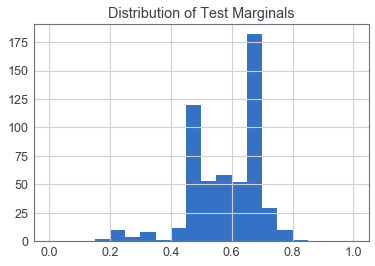

In [11]:
# plot the test marginals
import matplotlib.pyplot as plt
plt.hist(test_marginals, bins=20, range=(0.0, 1.0))
plt.title('Distribution of Test Marginals')
plt.show()

In [12]:
# export all candidates to csv file
df = pd.DataFrame({'id': [], 'virus': [], 'host': []})

# list all candidates (to export later and merge w predicted probabilities table?)
for c in session.query(VirusHost).all():
    df = df.append({'id': c.id, 'virus': c.virus.get_attrib_tokens("words"), 'host': c.host.get_attrib_tokens("words")}, ignore_index=True)
    
df2 = df[:]
df2['virus'] = df['virus'].str.join(' ')
df2['host'] = df['host'].str.join(' ')
df2['virus'] = df2['virus'].str.replace('[^a-zA-Z ]', '')
df2['host'] = df2['host'].str.replace('[^a-zA-Z ]', '')
df2['id'] = df['id'].astype('int64')
df2.to_csv('candidates.csv', index = False)

In [13]:
# exported marginals table using sqlite to a csv file, deleted unneeded columns, edited column names to 'id' and 'probability_positive' using Excel